In [19]:
import numpy as np
import pandas as pd

In [20]:
path = 'data/dirty_cafe_sales.csv'

df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


## Preprocessing

In [21]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [22]:
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)

0


In [23]:
num_columns = ['Quantity', 'Price Per Unit', 'Total Spent']
df[num_columns] = df[num_columns].replace({'UNKNOWN': np.nan, 'ERROR': np.nan}).astype(float)

# Count missing values in cost columns
num_missing_vals = df[num_columns].isna().sum(axis=1)

# Impute missing values where possible

#   Quantity = Total Spent / Price Per Unit
no_quantity = df[df['Quantity'].isna() & (num_missing_vals < 2)]
no_quantity = no_quantity['Total Spent'] / no_quantity['Price Per Unit']
df.loc[no_quantity.index, 'Quantity'] = no_quantity

#   Price Per Unit = Total Spent / Quantity
no_ppu = df[df['Price Per Unit'].isna() & (num_missing_vals < 2)]
no_ppu = no_ppu['Total Spent'] / no_ppu['Quantity']
df.loc[no_ppu.index, 'Price Per Unit'] = no_ppu

#   Total Spent = Quantity * Price Per Unit
no_total = df[df['Total Spent'].isna() & (num_missing_vals < 2)]
no_total = no_total['Quantity'] * no_total['Price Per Unit']
df.loc[no_total.index, 'Total Spent'] = no_total

# Drop rows with any remaining missing values in cost columns (these cannot be imputed as 2+ values are missing)
df.dropna(subset=num_columns, inplace=True)
df.shape

(9942, 8)

In [24]:
cat_columns = ['Item', 'Payment Method', 'Location']
df[cat_columns] = df[cat_columns].fillna('UNKNOWN')

df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')

In [25]:
# Not knowing the Item purchased makes the record useless for analysis
df = df[(df['Item'] != 'UNKNOWN') & (df['Item'] != 'ERROR')]
df['Item'].value_counts()

Item
Juice       1167
Coffee      1158
Salad       1144
Cake        1134
Sandwich    1122
Smoothie    1089
Cookie      1084
Tea         1081
Name: count, dtype: int64

In [26]:
df.dropna(subset=['Transaction Date'], inplace=True)

df['Day'] = df['Transaction Date'].dt.day
df['Month'] = df['Transaction Date'].dt.month
df['Year'] = df['Transaction Date'].dt.year

In [27]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date,Day,Month,Year
0,TXN_1961373,Coffee,2.0,2.0,4.0,Credit Card,Takeaway,2023-09-08,8,9,2023
1,TXN_4977031,Cake,4.0,3.0,12.0,Cash,In-store,2023-05-16,16,5,2023
2,TXN_4271903,Cookie,4.0,1.0,4.0,Credit Card,In-store,2023-07-19,19,7,2023
3,TXN_7034554,Salad,2.0,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27,27,4,2023
4,TXN_3160411,Coffee,2.0,2.0,4.0,Digital Wallet,In-store,2023-06-11,11,6,2023


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8564 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction ID    8564 non-null   object        
 1   Item              8564 non-null   object        
 2   Quantity          8564 non-null   float64       
 3   Price Per Unit    8564 non-null   float64       
 4   Total Spent       8564 non-null   float64       
 5   Payment Method    8564 non-null   object        
 6   Location          8564 non-null   object        
 7   Transaction Date  8564 non-null   datetime64[ns]
 8   Day               8564 non-null   int32         
 9   Month             8564 non-null   int32         
 10  Year              8564 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(3), object(4)
memory usage: 702.5+ KB


## Analysis

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# For comma formatting in plots
import matplotlib.ticker as mtick

In [30]:
revenue_by_item = df.groupby('Item')['Total Spent'].sum().sort_values(ascending=False)
print(revenue_by_item)

Item
Salad       16545.0
Sandwich    12996.0
Smoothie    12736.0
Juice       10017.0
Cake         9807.0
Coffee       6800.0
Tea          4639.5
Cookie       3065.0
Name: Total Spent, dtype: float64


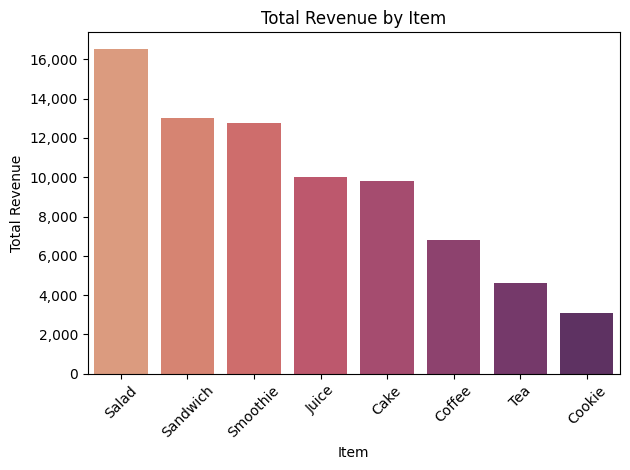

In [31]:
ax = sns.barplot(
    x=revenue_by_item.index,
    y=revenue_by_item.values,
    hue=revenue_by_item.index,
    palette='flare',
    legend=False
)

plt.xticks(rotation=45)
plt.xlabel('Item')
plt.ylabel('Total Revenue')
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.title('Total Revenue by Item')
plt.tight_layout()

In [32]:
number_sold_by_item = df.groupby('Item')['Quantity'].sum().sort_values(ascending=False)
print(number_sold_by_item)

Item
Coffee      3400.0
Juice       3339.0
Salad       3309.0
Cake        3269.0
Sandwich    3249.0
Smoothie    3184.0
Tea         3093.0
Cookie      3065.0
Name: Quantity, dtype: float64


Month
January      278.0
February     286.0
March        325.0
April        256.0
May          251.0
June         295.0
July         291.0
August       299.0
September    223.0
October      340.0
November     246.0
December     310.0
Name: Quantity, dtype: float64


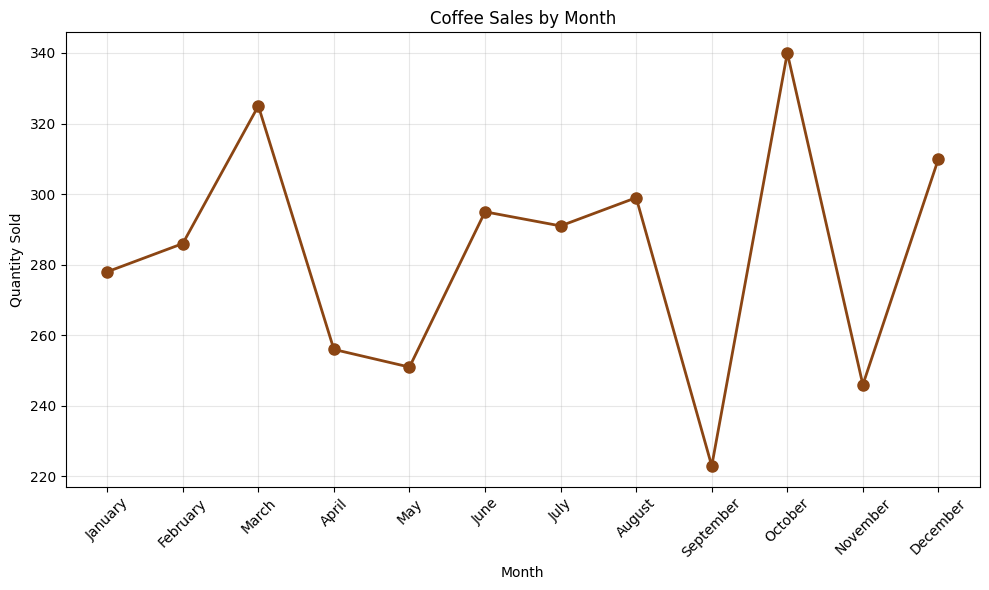

In [33]:
coffee_sales_by_month = df[df['Item'] == 'Coffee'].groupby('Month')['Quantity'].sum().sort_index()

# Convert month numbers to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
coffee_sales_by_month.index = coffee_sales_by_month.index.map(month_names)

print(coffee_sales_by_month)

plt.figure(figsize=(10, 6))
plt.plot(coffee_sales_by_month.index, coffee_sales_by_month.values, marker='o', linewidth=2, markersize=8, color='#8B4513')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.title('Coffee Sales by Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()

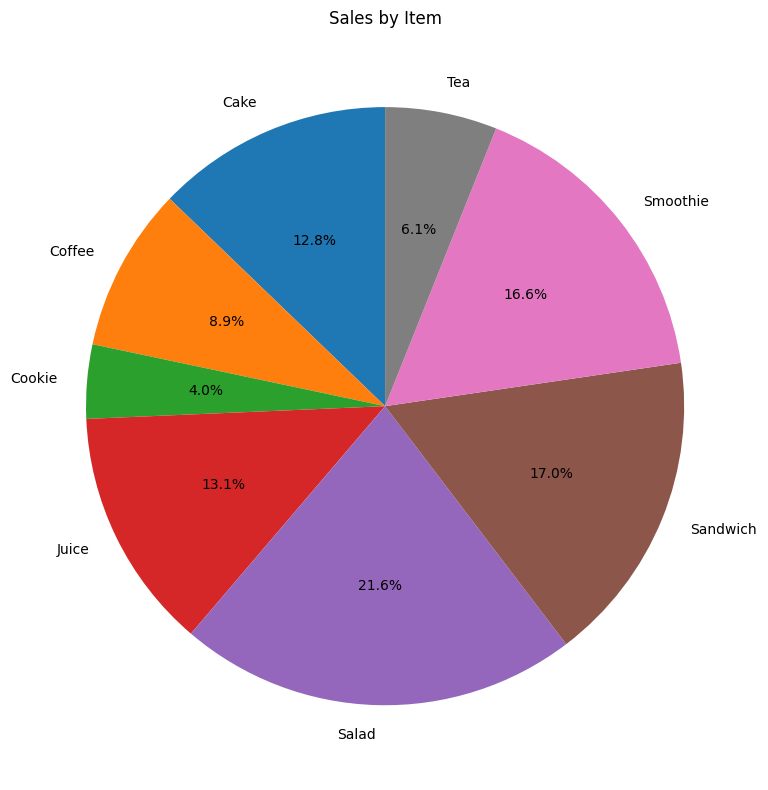

In [34]:
sales_by_item = df.groupby('Item')['Total Spent'].sum()

plt.figure(figsize=(10, 8))
plt.pie(sales_by_item.values, labels=sales_by_item.index, autopct='%1.1f%%', startangle=90)
plt.title('Sales by Item')
plt.tight_layout()


Average Transaction Value by Day of Week:
DayOfWeek
Monday       8.785311
Tuesday      9.254445
Wednesday    8.705907
Thursday     9.000807
Friday       9.007618
Saturday     8.952440
Sunday       8.913370
Name: Total Spent, dtype: float64


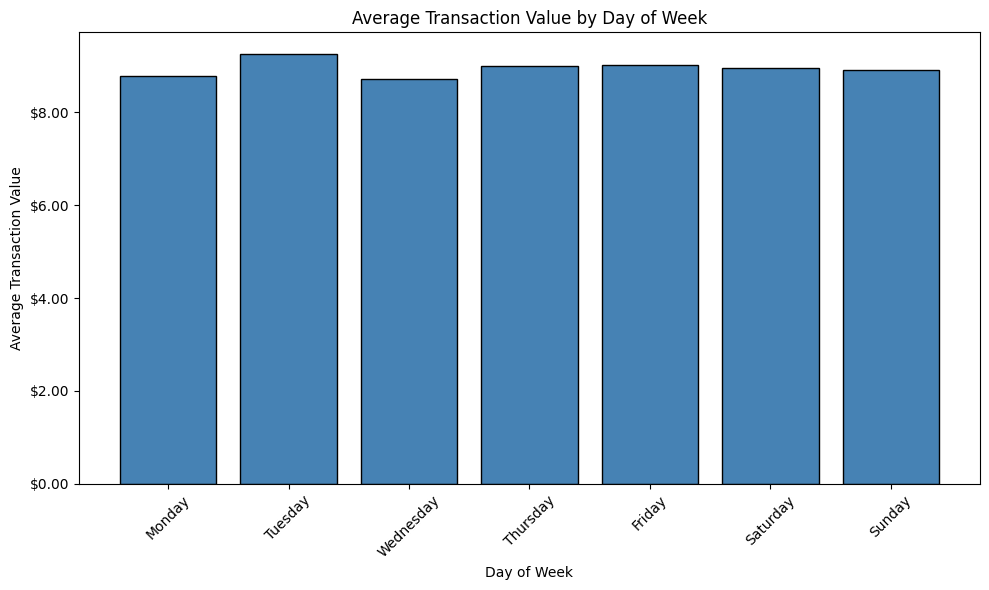

In [37]:
# Extract day of week from Transaction Date
df['DayOfWeek'] = df['Transaction Date'].dt.day_name()

# Average transaction value by day of week
avg_transaction_by_dow = df.groupby('DayOfWeek')['Total Spent'].mean()

# Reorder by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_transaction_by_dow = avg_transaction_by_dow.reindex(day_order)

print("\nAverage Transaction Value by Day of Week:")
print(avg_transaction_by_dow)

plt.figure(figsize=(10, 6))
plt.bar(range(len(avg_transaction_by_dow)), avg_transaction_by_dow.values, color='steelblue', edgecolor='black')

plt.xlabel('Day of Week')
plt.ylabel('Average Transaction Value')
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
plt.title('Average Transaction Value by Day of Week')
plt.xticks(range(len(avg_transaction_by_dow)), avg_transaction_by_dow.index, rotation=45)
plt.tight_layout()